# How to Search and Access Giovanni Variable Zarr Stores

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Warning:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

<p></p>


### Overview

This notebook demonstrates how to search and access Giovanni Variable Zarr Stores inside the [AWS us-west-2](https://disc.gsfc.nasa.gov/information/documents?title=Migrating%20to%20the%20Cloud) region. It uses the python-cmr library to query the Zarr stores by provider, collection, and version, and several other Python libraries for authenticating and opening the Zarr store S3 buckets.

### Prerequisites

This notebook was written using Python 3.9, and requires these libraries and files: 
- netrc file with valid Earthdata Login credentials.
  - [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- Xarray
- requests
- S3FS
- Boto3
- NumPy
- Matplotlib
- Seaborn
- Pandas
- python-cmr


### Import Libraries

In [2]:
#import s3fs
#import zarr
import requests
import xarray as xr
from cmr import VariableQuery
#import boto3
from IPython.display import display, Markdown
import re
import warnings
warnings.filterwarnings('ignore', message='.*Converting non-nanosecond precision datetime values to nanosecond precision.*')
%matplotlib inline


### Check AWS Region before running notebook

A common error when executing this notebook occurs when the notebook is run outside of the us-west-2 AWS region. Here, we check the region using the Boto3 Python library, and throw a ValueError if you are outside the region.

This cell is not necessary to access the S3 buckets for users inside the us-west-2 region, and can be commented out or deleted at the users' discretion.

In [2]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

### us-west-2 Region Check: &#x2705;

### Use CMR to search for all available variable zarr stores

Define a function for retrieving S3 bucket credentials from the Giovanni API. These credentials will only be valid for one hour.

In [3]:
def retrieve_credentials():
    """Makes the Oauth calls to authenticate with EDS and return a set of s3 same-region, read-only credentials."""
    response = requests.get("https://api.giovanni.earthdata.nasa.gov/s3credentials")
    response.raise_for_status()
    return response.json()

Define functions for querying Zarr stores by provider, collection, and version.

In [4]:
def query_all_zarr_stores(provider = None):
    api = VariableQuery()
    if provider: 
        all_vars = api.provider(provider).get_all()
    else:
        all_vars = api.get_all()

    zarrs = []
    for variable_entry in all_vars:
        try:
            if variable_entry['instance_information']['format'] == 'zarr':
                zarrs.append(variable_entry)
        except KeyError:
            continue
    return zarrs
    
def find_single_zarr_store(short_name, version, provider = None, variable = None):
    zarr_stores = query_all_zarr_stores(provider = provider)
    zarrs = []
    if variable:
        pattern = short_name + '.*' + version + '.*' + variable + '.*'
    else:         
        pattern = short_name + '.*' + version + '.*'

    for store in zarr_stores:
        try:
            if re.match(pattern, store["native_id"]):
                zarrs.append(store)
        except KeyError:
            continue
    return zarrs

Create function to open the Zarr store using the S3FS library

In [5]:
def get_zarr_store(credentials, cmr_variable_metadata):
    s3 = s3fs.S3FileSystem(
        key=credentials["AccessKeyId"],
        secret=credentials["SecretAccessKey"],
        token=credentials["SessionToken"],
    )
    
    store = s3fs.S3Map(
        root=cmr_variable_metadata['instance_information']['url'], s3=s3, check=False
    )
    return store

### Query all Zarr Stores by Provider

In [6]:
all_zarr_metadata = query_all_zarr_stores(provider = 'GES_DISC')
print('Found ' + str(len(all_zarr_metadata)) + ' zarr stores')

Found 25 zarr stores


View the metadata for one random zarr store found:

In [7]:
all_zarr_metadata[0]

{'long_name': 'Average Surface Skin temperature',
 'definition': 'AvgSurfT_inst',
 'name': '/AvgSurfT_inst',
 'concept_id': 'V3084751920-GES_DISC',
 'associations': {'collections': ['C1233767545-GES_DISC']},
 'revision_id': 3,
 'provider_id': 'GES_DISC',
 'native_id': 'GLDAS_NOAH025_3H_2.0_/AvgSurfT_inst',
 'instance_information': {'url': 's3://prod-giovanni-cache/zarr/GLDAS_NOAH025_3H_2_0_AvgSurfT_inst',
  'format': 'zarr',
  'chunking_information': '18, 36, 800',
  'direct_distribution_information': {'region': 'us-west-2',
   's_3_credentials_api_endpoint': 'https://api.giovanni.earthdata.nasa.gov/s3credentials',
   's_3_credentials_api_documentation_url': 'https://api.giovanni.earthdata.nasa.gov/s3credentials'}},
 'association_details': {'collections': [{'concept_id': 'C1233767545-GES_DISC'}]}}

Under the available CMR metadata, you will find information about the specific collection, version and variable the zarr store is associated with. You will also find the S3 URL for any specific zarr store under ```instance_information``` and ```url```. 

You can already use one of these metadata records along with the ```retrieve_credentials``` and ```get_zarr_store``` functions to obtain the data from AWS. 

In [8]:
credentials = retrieve_credentials()
store = get_zarr_store(credentials,all_zarr_metadata[0])

### Query Zarr stores by Collection, Version, or Variable

Alternatively you can further search for a specific collection, version and variable using the ```query_zarr_stores``` function.

In [9]:
short_name = "GLDAS_NOAH025_3H"
version = "2.0"
variable = "RootMoist_inst"
provider = "GES_DISC"

In [10]:
zarr_metadata = find_single_zarr_store(short_name,version,provider,variable)
zarr_metadata

[{'long_name': 'Root zone soil moisture',
  'definition': 'RootMoist_inst',
  'name': '/RootMoist_inst',
  'concept_id': 'V3084751858-GES_DISC',
  'associations': {'collections': ['C1233767545-GES_DISC']},
  'revision_id': 2,
  'provider_id': 'GES_DISC',
  'native_id': 'GLDAS_NOAH025_3H_2.0_/RootMoist_inst',
  'instance_information': {'url': 's3://prod-giovanni-cache/zarr/GLDAS_NOAH025_3H_2_0_RootMoist_inst',
   'format': 'zarr',
   'chunking_information': '18, 36, 800',
   'direct_distribution_information': {'region': 'us-west-2',
    's_3_credentials_api_endpoint': 'https://api.giovanni.earthdata.nasa.gov/s3credentials',
    's_3_credentials_api_documentation_url': 'https://api.giovanni.earthdata.nasa.gov/s3credentials'}},
  'association_details': {'collections': [{'concept_id': 'C1233767545-GES_DISC'}]}}]

In [11]:
credentials = retrieve_credentials()
store = get_zarr_store(credentials,zarr_metadata[0])

### Open Zarr Store using Xarray

In [12]:
data = xr.open_zarr(store=store, consolidated=False)
data = data.where(data["time"] != data["time"]._FillValue, drop=True)
data = data.sortby('time')

data

<xarray.Dataset> Size: 681GB
Dimensions:           (latitude: 600, bounds: 2, time: 195775, longitude: 1440)
Coordinates:
  * latitude          (latitude) float64 5kB -59.88 -59.62 ... 89.62 89.88
  * longitude         (longitude) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * time              (time) datetime64[ns] 2MB 1948-01-01T03:00:00 ... 2014-...
Dimensions without coordinates: bounds
Data variables:
    latitude_bounds   (latitude, bounds, time) float64 2GB dask.array<chunksize=(18, 2, 195775), meta=np.ndarray>
    longitude_bounds  (longitude, bounds, time) float32 2GB dask.array<chunksize=(36, 2, 195775), meta=np.ndarray>
    time_bounds       (time, bounds) datetime64[s] 3MB dask.array<chunksize=(800, 2), meta=np.ndarray>
    variable          (latitude, longitude, time) float32 677GB dask.array<chunksize=(18, 36, 800), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.10
    DOI:                 10.5067/342OHQM9AK6Q
    product_long_name:   GLDAS Noah Land Surface Model L4 3 hourly 0.25 x 0.2...
    product_short_name:  GLDAS_NOAH025_3H
    product_version:     2.0

### Visualize a time series

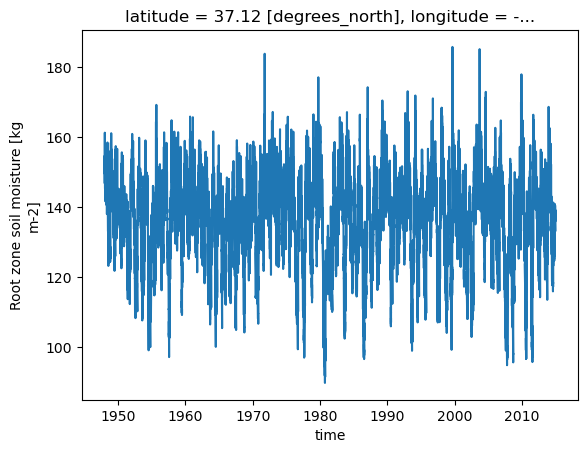

In [13]:
data.variable.sel(latitude=37.05, longitude=-76.35,method = 'nearest').plot()

### Vizualize a map

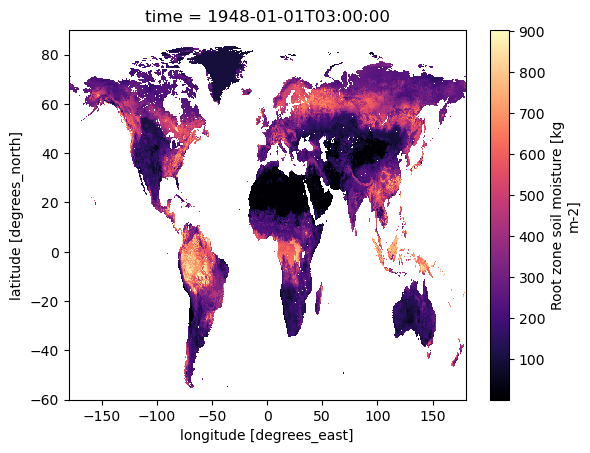

In [14]:
data['variable'].isel(time = 0).plot(x='longitude',y='latitude',cmap='magma')

# Acknowledgments

Openscapes for providing Jupyter Hub access, Faith Giguere for the method to get temporary AWS credentials, and the Cloud Giovanni team for contributing to this epic.